In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import tkp.db
import tkp.config
import logging
import csv
import time
import sys
import itertools

import numpy as np
import pandas as pd
import scipy as sp

from astropy import units as u
from astropy.coordinates import SkyCoord

import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

import pylab

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


In [3]:
def dump_trans(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    # find all the new, candidate transient, sources detected by the pipeline
    transients_query = """
    SELECT  tr.runcat
           ,tr.newsource_type
           ,im.rms_min
           ,im.rms_max
           ,im.detection_thresh
           ,ex.f_int
    FROM newsource tr
         ,image im
         ,extractedsource ex
    WHERE tr.previous_limits_image = im.id
      AND tr.trigger_xtrsrc = ex.id
    """
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients

def dump_sources(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    # extract the properties and variability parameters for all the running catalogue sources in the dataset
    sources_query = """\
    SELECT  im.taustart_ts
            ,im.tau_time
            ,ex.f_int
            ,ex.f_int_err
            ,ax.xtrsrc
            ,ex.extract_type
            ,rc.id as runcatid
            ,rc.dataset
            ,ex.ra
            ,ex.decl
            ,rc.wm_ra
            ,rc.wm_decl
            ,ex.ra_err
            ,ex.decl_err
            ,im.band
            ,ax.v_int
            ,ax.eta_int
            ,ax.f_datapoints
            ,im.freq_eff
    FROM extractedsource ex
         ,assocxtrsource ax
         ,image im
         ,runningcatalog rc
         ,runningcatalog_flux rf
    WHERE rf.runcat = rc.id
      and ax.runcat = rc.id
      AND ax.xtrsrc = ex.id
      and ex.image = im.id
      AND rc.dataset = %s
      ORDER BY rc.id
    """
    cursor = tkp.db.execute(sources_query, (dataset_id,))
    sources = tkp.db.generic.get_db_rows_as_dicts(cursor)

    print "Found", len(sources), "source datapoints"

    return sources 

In [4]:
def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [5]:
def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    
#     source_df = source_df.groupby('taustart_ts', as_index=False)
    source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df.sort_index()


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


    plt.rcParams['font.size']=16
    plt.rcParams['axes.labelsize']='large'
    plt.rcParams['axes.titlesize']='large'
    pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    # plt.title("Source: N = {}".format(len(source_df["f_int"].values[np.isfinite(source_df["f_int"])])))
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    # plt.ylabel("Normalized N")
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure
#     plt.show()
# fig.text(0.5, 0.04, 'date', ha='center')
# plt.tight_layout()
# print(source_df["wm_ra"].values[0],source_df["wm_decl"].values[1])
# plt.savefig("{}_multiday_lightcurve.png".format(key))



In [6]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'
# database = 'raw_16SB'
# database = 'flux_16SB'
# database = 'fluxcal_db'

# databases = ['higher_201702250130','lower_201702250130']
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

## Load single database 

#### Sources

In [7]:
# db._configured = False
# del data
t1 = time.time()
dbname = "_201702250130"

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()
sources = dump_sources(dbname,2, engine, host, port, user, password)
print len(sources)
data = pd.DataFrame(sources)

del sources

data.taustart_ts = pd.to_datetime(data.taustart_ts)

bool_index = [x.year == 2018 for x in data.taustart_ts]
data = data.drop(data.index[bool_index])
data = data.drop(data.index[np.abs(data.f_int) > 10e6])
data = data.drop(data.index[np.logical_or((data.set_index("taustart_ts").index.month != 2), \
                           (data.set_index("taustart_ts").index.hour == 14))])

del bool_index

db._configured = False
del db, session

print time.time() - t1, "seconds."

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201702250130


database name:  _201702250130


INFO:tkp.db.database:connecting to database...


Found 6742435 source datapoints
6742435
1846.91216993 seconds.


#### Transients 

In [9]:
t1 = time.time()
dbname = "_201702250130"

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()
transients = dump_trans(dbname,2, engine, host, port, user, password)
print len(transients)
trans_data = pd.DataFrame(transients)

del transients

# trans_data.taustart_ts = pd.to_datetime(trans_data.taustart_ts)

# bool_index = [x.year == 2018 for x in trans_data.taustart_ts]
# trans_data = data.drop(data.index[bool_index])
# trans_data = data.drop(data.index[np.abs(data.f_int) > 10e6])
# trans_data = data.drop(data.index[(data.set_index("taustart_ts").index.month != 2) & \
#                            (data.set_index("taustart_ts").index.hour == 14)])

# del bool_index

db._configured = False
del db, session

print time.time() - t1, "seconds."

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201702250130
INFO:tkp.db.database:connecting to database...


database name:  _201702250130


Found 2304 new sources
2304
0.357253074646 seconds.


In [10]:
trans_data = trans_data[trans_data.runcat >= 160]

# print np.max(data.runcatid), np.max(trans_data.runcat)

## Load multiple databases.

In [19]:
# db._configured = False
# del data
data = pd.DataFrame([])

for dbname in databases:
    print "database name: ",  dbname

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)
    db.connect()
    session = db.Session()

    sources = dump_sources(dbname,1, engine, host, port, user, password)

    if len(data) == 0:
        data = pd.DataFrame(sources)
        del sources
        data.taustart_ts = pd.to_datetime(data.taustart_ts)
        data.band = np.ones(len(data.band), dtype=int)

    else:
        new_data = pd.DataFrame(sources)
        del sources

        new_data.taustart_ts = pd.to_datetime(new_data.taustart_ts)
        new_data.runcatid += data.runcatid.iloc[-1]
        new_data.band = (data.band.iloc[-1]+1)*np.ones(len(new_data.band), dtype=int)

        data = pd.concat([data,new_data], ignore_index=True)
        del new_data
        
    db._configured = False
    del db, session

NameError: name 'databases' is not defined

#### Save all data

In [ ]:
all_data_name = "all_raw_data.csv"
data.to_csv(all_data_name, index=True)

#### Load all data

In [ ]:
all_data_name = "fb_flux_all_raw_data.csv"
data = pd.read_csv(all_data_name, infer_datetime_format=True)

## Clean Catalogue

In [8]:
# Detection in both subbands, simultaneously, in > N_detections timesteps. 

N_detections = 0 


# multi_detections = [] 
reduced = pd.DataFrame([])


t1 = time.time()
for _id in np.unique(data.runcatid):
    if len(data[(data.runcatid == _id) & \
                (data.band == 23) & \
                (data.extract_type == 0)].set_index("taustart_ts").index.\
           intersection(data[(data.runcatid == _id) & \
                             (data.band == 24) & \
                             (data.extract_type == 0)].set_index("taustart_ts").index )) > N_detections:

#         multi_detections.append(run_index)
        if len(reduced) == 0:
            reduced = pd.DataFrame(data[(data.runcatid == _id)])
        else:
            reduced = pd.concat([reduced,data[(data.runcatid == _id)]])

print time.time() - t1

1198.11374903


In [9]:
base = reduced.groupby("runcatid").mean()

In [10]:
print len(base), len(np.unique(data.runcatid))

1133 2586


In [13]:
# reduced_low = pd.DataFrame([])
# reduced_hi = pd.DataFrame([])

reduced = pd.DataFrame([])

for _id in multi_detections:
#     if len(reduced_low) == 0:
#         reduced_low = pd.DataFrame(data[(data.runcatid == _id) & \
#                                        (data.band == 23)])
#         reduced_hi = pd.DataFrame(data[(data.runcatid == _id) & \
#                                        (data.band == 24)])
#     else:
#         reduced_low = pd.concat([reduced_low,data[(data.runcatid == _id) & \
#                                        (data.band == 23)]])
#         reduced_hi = pd.concat([reduced_hi,data[(data.runcatid == _id) & \
#                                        (data.band == 24)]])
 
    if len(reduced) == 0:
        reduced = pd.DataFrame(data[(data.runcatid == _id)])
    else:
        reduced = pd.concat([reduced,data[(data.runcatid == _id)]])

## Match catalogues

In [66]:
vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", comment="#", delimiter="\t")
tgss = pd.read_csv("/home/kuiack/TGSSADR1_7sigma_catalog.tsv", delimiter="\t")

,Source_name,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,E_Maj,Min,E_Min,PA,E_PA,RMS_noise,Source_code,Mosaic_name
0,TGSSADR J001951.8-513004,4.96617,2.0,-51.50132,2.1,246.1,25.1,227.0,22.8,77.3,1.4,25.9,0.2,-1.4,90.0,3.0,S,R01D02
1,TGSSADR J001943.6-520839,4.93207,2.0,-52.14418,2.4,190.0,20.3,160.0,16.5,78.6,3.0,27.8,0.4,-0.5,90.0,4.5,S,R01D02
2,TGSSADR J001847.7-505314,4.69904,2.0,-50.88739,2.6,78.4,9.2,75.3,7.9,74.5,4.0,25.8,0.5,-0.5,0.0,2.9,S,R01D02
3,TGSSADR J001848.9-511458,4.70384,2.0,-51.24956,2.0,3515.3,351.6,3072.1,307.2,77.4,0.1,27.5,0.0,-0.7,0.0,2.8,M,R01D02
4,TGSSADR J001859.0-522216,4.74587,2.0,-52.37137,2.7,199.1,21.1,123.6,13.1,84.3,4.2,35.2,0.9,-7.7,0.7,4.6,S,R01D02
5,TGSSADR J001840.0-510513,4.66706,2.4,-51.08710,7.3,30.7,5.2,21.2,3.2,90.7,16.7,29.5,2.1,6.2,4.8,2.8,S,R01D02
6,TGSSADR J001822.7-502928,4.59484,2.0,-50.49120,2.0,562.2,56.4,510.4,51.1,74.7,0.6,27.2,0.1,-0.7,90.0,2.9,S,R01D02
7,TGSSADR J001810.0-505538,4.54188,2.0,-50.92740,2.2,121.6,13.0,122.3,12.4,73.2,2.3,25.0,0.3,-1.2,90.0,2.8,S,R01D02
8,TGSSADR J001828.9-523334,4.62078,2.0,-52.55950,2.9,101.7,12.9,101.3,10.8,75.3,4.9,24.6,0.5,-1.2,0.2,4.7,S,R01D02
9,TGSSADR J001823.5-521949,4.59823,2.0,-52.33037,2.2,265.9,27.4,215.3,21.9,77.7,2.1,29.3,0.3,-3.8,90.0,4.3,S,R01D02


(0, 90)

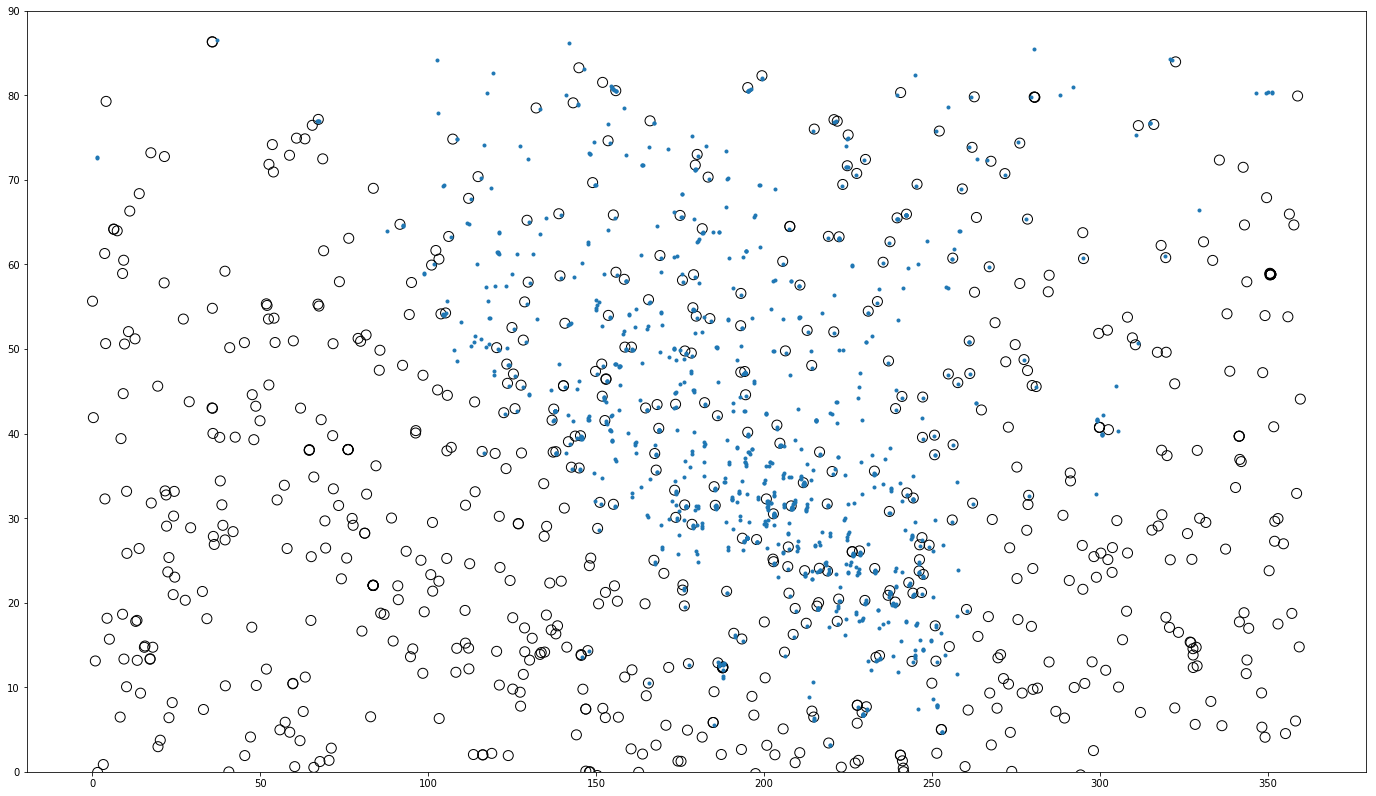

In [32]:
thresh = 10
plt.figure(figsize=(24,14))
plt.plot(base.ra, base.decl, ".")
plt.scatter(vlssr[vlssr.Sp > thresh]._RAJ2000, 
            vlssr[vlssr.Sp > thresh]._DEJ2000,
            s=100,facecolor='none', edgecolor="k")
plt.ylim([0,90])

In [35]:
thresh = 10

base_coord = SkyCoord(ra=(base.ra*u.degree).values, dec=(base.decl*u.degree).values)

vlssr_coord = SkyCoord(ra=(vlssr[vlssr.Sp > thresh]._RAJ2000*u.degree).values,
                       dec=(vlssr[vlssr.Sp > thresh]._DEJ2000*u.degree).values)

idx, d2d, d3d = base_coord.match_to_catalog_sky(vlssr_coord) 




AttributeError: 'DataFrame' object has no attribute 'show'

In [ ]:
2579, 2460, 1260, 1985

0.1 1126


,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,tau_time,v_int,wm_decl,wm_ra,xtrsrc
runcatid,,,,,,,,,,,,,,,,,
1260,23.513604,2.0,17.370760,0.358872,2.637625,0.342403,598.192131,33.952755,10.696176,6.002465e+07,245.208824,0.338508,1.003349,0.484542,17.401679,245.229379,1.598178e+06
1985,23.504425,2.0,15.543459,0.753801,1.281949,0.721239,57.004425,20.608593,10.820841,6.004647e+07,246.539707,0.667101,1.000000,0.613855,15.494353,246.500043,1.903673e+06
2152,23.479424,2.0,41.677877,0.086246,0.098001,0.004969,1966.073003,90.670834,21.073403,6.014210e+07,299.126298,0.103031,-3.157090,0.069535,41.663507,299.126675,1.984571e+06
2444,23.044025,2.0,42.242024,0.161969,0.051136,0.062893,73.308176,48.921692,18.542994,6.166184e+07,301.013770,0.187730,1.006289,0.062689,42.241927,301.013842,1.985020e+06
2460,23.500000,2.0,17.302799,0.403038,4.551349,0.466418,134.500000,28.916430,9.591422,6.006508e+07,245.168167,0.357730,1.000000,0.631657,17.357757,245.209977,2.080489e+06
2473,23.499749,2.0,41.620041,0.076111,0.113443,0.007541,995.000251,88.611347,19.637413,6.007306e+07,299.120736,0.097186,-7.208899,0.071675,41.612906,299.128116,2.165071e+06
2579,23.495146,2.0,17.651393,0.518772,7.301975,0.601942,52.004854,22.535451,9.175350,6.008248e+07,245.410252,0.456978,1.000000,0.918543,17.664265,245.419613,2.137286e+06


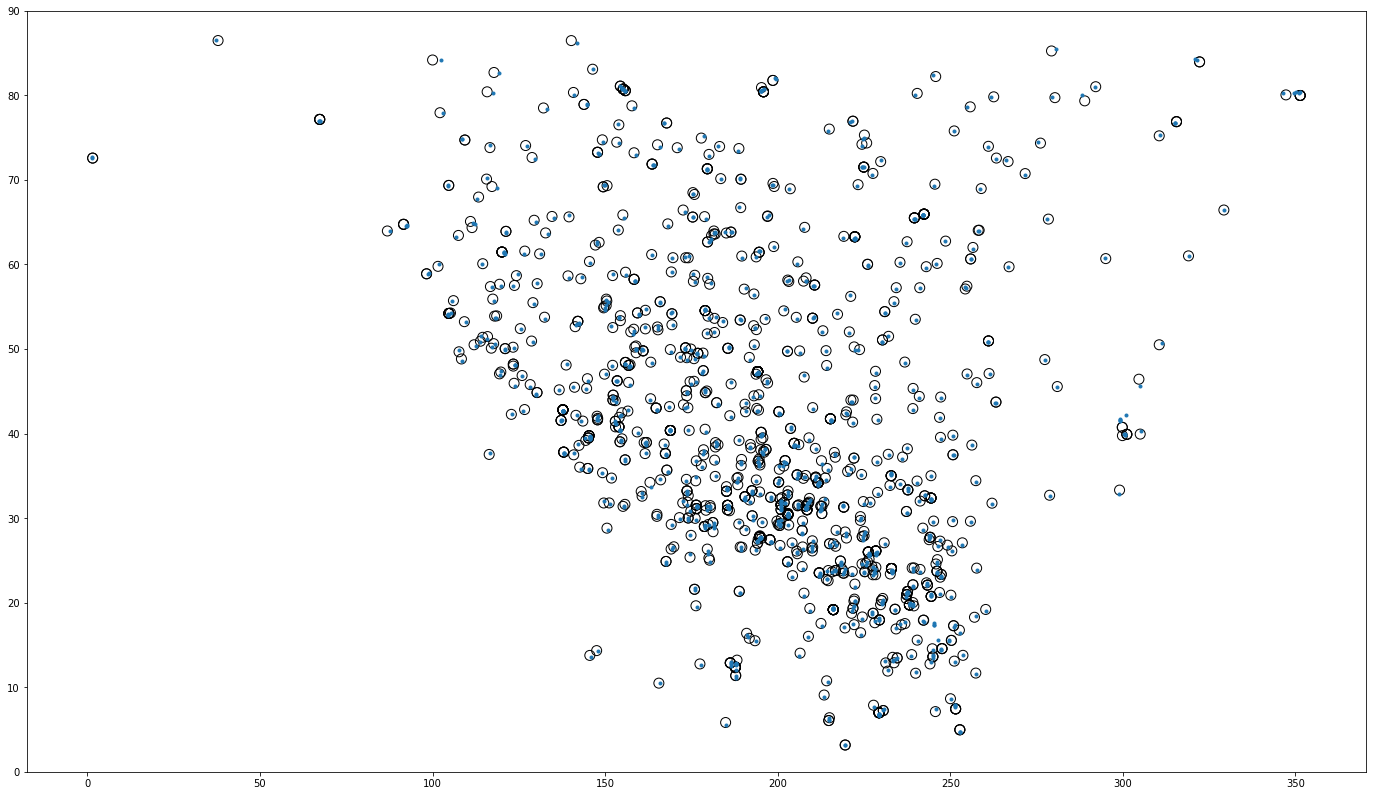

In [106]:
thresh = 0.1
radius = 1.

# for thresh in [.1,.5,1,2,4,7,10]:

base_coord = SkyCoord(ra=(base.ra*u.degree).values, dec=(base.decl*u.degree).values)

vlssr_coord = SkyCoord(ra=(vlssr[vlssr.Sp > thresh]._RAJ2000*u.degree).values,
                       dec=(vlssr[vlssr.Sp > thresh]._DEJ2000*u.degree).values)

idx, d2d, d3d = base_coord.match_to_catalog_sky(vlssr_coord) 



plt.figure(figsize=(24,14))

plt.plot(base.ra,base.decl,".")
plt.scatter(vlssr[vlssr.Sp > thresh].iloc[idx[d2d.deg < radius]]._RAJ2000, 
            vlssr[vlssr.Sp > thresh].iloc[idx[d2d.deg < radius]]._DEJ2000,
            s=100,facecolor='none', edgecolor="k")

plt.ylim([0,90])
print thresh, len(idx[d2d.deg < radius])
base[d2d.deg > radius]

In [89]:
np.logspace(2,5,20)

array([    100.        ,     143.84498883,     206.91380811,
           297.63514416,     428.13323987,     615.84821107,
           885.86679041,    1274.2749857 ,    1832.98071083,
          2636.65089873,    3792.69019073,    5455.59478117,
          7847.59970351,   11288.37891685,   16237.76739189,
         23357.2146909 ,   33598.18286284,   48329.30238572,
         69519.27961776,  100000.        ])

In [98]:
thresh = 1000
radius = 1.

n_assoc = []

for thresh in np.logspace(2,5,100):

    base_coord = SkyCoord(ra=(base.ra*u.degree).values, dec=(base.decl*u.degree).values)

    tgss_coord = SkyCoord(ra=(tgss[tgss.Total_flux > thresh].RA*u.degree).values,
                           dec=(tgss[tgss.Total_flux > thresh].DEC*u.degree).values)

    idx, d2d, d3d = base_coord.match_to_catalog_sky(tgss_coord) 



#     plt.figure(figsize=(24,14))

#     plt.plot(base.ra,base.decl,".")
#     plt.scatter(tgss[tgss.Total_flux > thresh].iloc[idx[d2d.deg < radius]].RA, 
#                 tgss[tgss.Total_flux > thresh].iloc[idx[d2d.deg < radius]].DEC,
#                 s=100,facecolor='none', edgecolor="k")

#     plt.ylim([0,90])
#     print thresh, len(idx[d2d.deg < radius])
#     base[d2d.deg > radius]
    n_assoc.append(len(idx[d2d.deg < radius]))

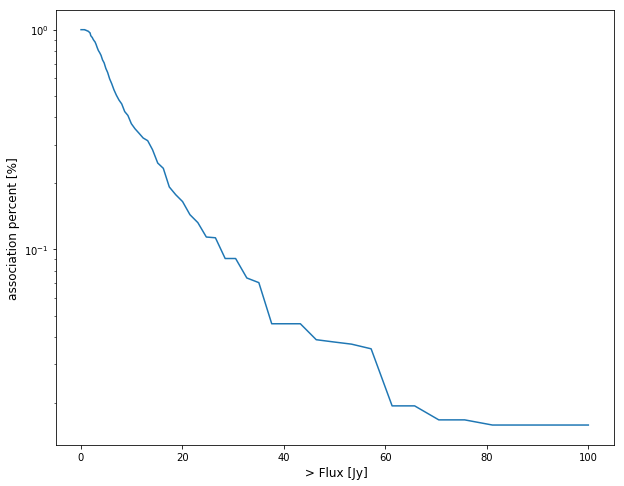

In [100]:
plt.figure(figsize=(10,8))
plt.plot(np.logspace(2,5,100)/1000,np.array(n_assoc)/1133. )
plt.xlabel(" > Flux [Jy]")
plt.ylabel("association percent [%]")
plt.yscale("log")

In [13]:
target_ra = 245
target_decl = 17
target_radius = 1.5

vlssr[(vlssr._RAJ2000 > target_ra-target_radius) & (vlssr._RAJ2000 < target_ra+target_radius) & \
(vlssr._DEJ2000 > target_decl-target_radius) & (vlssr._DEJ2000 < target_decl+target_radius)]

,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,Sp,e_Sp,MajAx,MinAx,PA,Rrms,Rpk,RFlx,Field,VLSS,img,SED
67105,243.62325,18.45919,16 14 29.58,+18 27 33.1,0.74,0.12,0.02,0.02,-45.68,0.09,0.22,0.01,1600+150,0,img,SED
67119,243.66774,18.37028,16 14 40.26,+18 22 13.0,0.73,0.13,0.02,0.02,-66.11,0.12,0.44,0.01,1600+150,1,img,SED
67133,243.70697,17.48701,16 14 49.67,+17 29 13.2,5.28,0.13,0.03,0.02,-78.72,0.12,0.33,0.01,1600+150,1,img,SED
67167,243.88506,15.57372,16 15 32.41,+15 34 25.4,0.88,0.14,0.02,0.02,75.17,0.12,0.28,0.00,1600+150,1,img,SED
67187,243.96916,16.72960,16 15 52.60,+16 43 46.6,2.47,0.16,0.02,0.02,47.24,0.20,0.62,0.02,1600+150,1,img,SED
67355,244.71425,15.66254,16 18 51.42,+15 39 45.2,0.87,0.17,0.03,0.02,48.13,0.15,0.36,0.01,1600+150,0,img,SED


In [77]:
target_ra = 245
target_decl = 17
target_radius = 1.

tgss[(tgss.RA > target_ra-target_radius) & (tgss.RA < target_ra+target_radius) & \
(tgss.DEC > target_decl-target_radius) & (tgss.DEC < target_decl+target_radius)]

,Source_name,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,E_Maj,Min,E_Min,PA,E_PA,RMS_noise,Source_code,Mosaic_name
453994,TGSSADR J161619.5+160031,244.08131,2.3,16.00877,2.3,47.9,8.5,42.4,6.0,27.2,2.8,26.0,2.5,67.9,90.0,4.1,S,R49D44
453995,TGSSADR J161609.7+161513,244.04076,2.1,16.25371,2.1,98.1,12.3,82.6,9.4,28.5,1.6,26.1,1.4,-8.0,26.4,4.3,S,R49D44
461698,TGSSADR J162202.9+160029,245.51225,2.4,16.00815,2.6,73.5,11.1,49.5,7.3,32.6,3.8,28.6,3.0,1.7,36.0,5.1,S,R50D43
461705,TGSSADR J162136.0+160040,245.40025,2.1,16.01126,2.2,97.8,13.2,81.2,9.7,28.7,2.0,26.4,1.7,-17.9,33.8,5.2,C,R50D43
461706,TGSSADR J162138.0+160058,245.40852,2.3,16.01636,2.4,80.9,11.8,57.3,7.9,33.5,3.5,26.5,2.3,40.4,18.9,5.2,C,R50D43
461896,TGSSADR J162337.3+175911,245.90561,2.1,17.98641,2.1,109.4,15.1,104.0,12.1,27.0,1.7,24.4,1.4,67.5,24.8,6.0,S,R50D45
461897,TGSSADR J162336.1+172205,245.90059,2.4,17.36810,3.1,98.5,14.0,54.1,8.7,40.2,5.7,28.3,3.1,9.0,18.1,6.4,S,R50D45
461898,TGSSADR J162324.2+163950,245.85094,2.6,16.66411,2.4,63.6,10.7,47.0,7.2,32.5,4.1,26.1,2.7,68.1,24.1,5.1,S,R50D45
461900,TGSSADR J162257.8+175247,245.74100,2.0,17.87983,2.1,242.1,26.8,184.1,19.8,30.7,1.3,26.8,1.0,13.1,12.8,6.8,S,R50D45
461901,TGSSADR J162256.6+170009,245.73599,2.2,17.00253,2.2,94.5,13.9,83.1,10.3,27.2,2.0,26.2,1.9,36.1,84.3,6.0,S,R50D45


In [76]:
re_tgss.to_csv("TGSS_reduced.csv",index=False)

In [56]:
target_ra = 245
target_decl = 17
target_radius = 2

base[(base.ra > target_ra-target_radius) & (base.ra < target_ra+target_radius) & \
(base.decl > target_decl-target_radius) & (base.decl < target_decl+target_radius)]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,tau_time,v_int,wm_decl,wm_ra,xtrsrc
runcatid,,,,,,,,,,,,,,,,,
1260,23.513604,2.0,17.370760,0.358872,2.637625,0.342403,598.192131,33.952755,10.696176,6.002465e+07,245.208824,0.338508,1.003349,0.484542,17.401679,245.229379,1.598178e+06
1985,23.504425,2.0,15.543459,0.753801,1.281949,0.721239,57.004425,20.608593,10.820841,6.004647e+07,246.539707,0.667101,1.000000,0.613855,15.494353,246.500043,1.903673e+06
2460,23.500000,2.0,17.302799,0.403038,4.551349,0.466418,134.500000,28.916430,9.591422,6.006508e+07,245.168167,0.357730,1.000000,0.631657,17.357757,245.209977,2.080489e+06
2579,23.495146,2.0,17.651393,0.518772,7.301975,0.601942,52.004854,22.535451,9.175350,6.008248e+07,245.410252,0.456978,1.000000,0.918543,17.664265,245.419613,2.137286e+06


In [ ]:
1260, 1985, 2460,2579

In [16]:
higher = SkyCoord(ra=np.array(data.ra, dtype=float)*u.degree,
                  dec=np.array(data.decl, dtype=float)*u.degree)

In [30]:
higher = SkyCoord(ra=(data[data.band == 1].ra*u.degree).values, dec=(data[data.band == 1].decl*u.degree).values)
lower = SkyCoord(ra=(data[data.band == 2].ra*u.degree).values, dec=(data[data.band == 2].decl*u.degree).values)

idx, d2d, d3d = lower.match_to_catalog_sky(higher)

In [62]:
trans_data

,detection_thresh,f_int,newsource_type,rms_max,rms_min,runcat
77,5.0,19.768934,0,18.743736,1.856205,218
78,5.0,19.327459,0,18.743736,1.856205,217
79,5.0,20.998830,0,18.743736,1.856205,216
80,5.0,77.739692,0,18.743736,1.856205,215
81,5.0,21.667495,0,22.866646,2.369417,222
82,5.0,24.460962,0,22.866646,2.369417,221
83,5.0,20.162994,0,22.866646,2.369417,220
84,5.0,19.622287,0,22.866646,2.369417,219
85,5.0,17.231162,0,18.205269,1.733188,225
86,5.0,25.159211,0,18.205269,1.733188,224


In [58]:
source_df.f_int_err[source_df.band == i]

taustart_ts
2017-02-25 01:32:30    6.549283
2017-02-25 01:33:39    6.132424
2017-02-25 01:33:46    6.991820
2017-02-25 01:34:26    6.428406
2017-02-25 01:34:28    6.182589
2017-02-25 01:34:40    6.838728
2017-02-25 01:34:47    6.594671
2017-02-25 01:34:49    6.350735
2017-02-25 01:36:08    6.532712
2017-02-25 01:36:09    5.836730
2017-02-25 01:36:12    6.460664
2017-02-25 01:36:33    5.889345
2017-02-25 01:36:36    6.139827
2017-02-25 01:36:38    6.514697
2017-02-25 01:36:41    6.521776
2017-02-25 01:38:26    6.464316
2017-02-25 01:38:28    6.256084
2017-02-25 01:38:38    6.570213
2017-02-25 01:38:39    6.428659
2017-02-25 01:38:41    6.594022
2017-02-25 01:38:43    7.076092
2017-02-25 01:40:24    7.046392
2017-02-25 01:40:26    6.382788
2017-02-25 01:40:27    6.578089
2017-02-25 01:40:28    6.771302
2017-02-25 01:40:29    6.628641
2017-02-25 01:40:56    6.833730
2017-02-25 01:40:57    6.331782
2017-02-25 01:40:58    6.509497
2017-02-25 01:41:00    6.678663
                         ...

In [8]:
source_df = retrieve_source(data, 300)
# source_df = source_df[source_df.index.year == 2017]


In [9]:
plt.errorbar(source_df.taustart_ts[source_df.band == i].values,source_df.f_int[source_df.band == i].values, 
                 yerr = source_df.f_int_err[source_df.band == i].values)


NameError: name 'i' is not defined

In [90]:
reduced = reduced.drop(reduced.index[np.logical_or((reduced.set_index("taustart_ts").index.month != 2), \
                           (reduced.set_index("taustart_ts").index.hour == 14))])

In [81]:
source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values

array(['2017-02-25T04:00:06.000000000+0000',
       '2017-02-25T04:00:06.000000000+0000',
       '2017-02-25T04:00:12.000000000+0000', ...,
       '2017-02-25T05:08:57.000000000+0000',
       '2017-02-25T14:07:20.000000000+0000',
       '2017-02-25T14:07:20.000000000+0000'], dtype='datetime64[ns]')

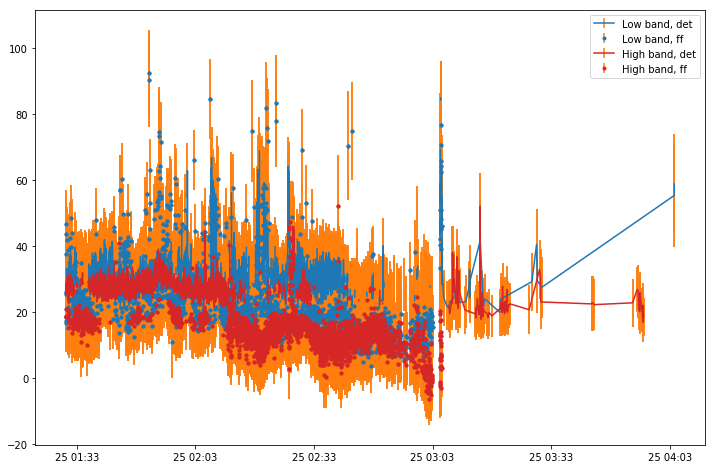

In [83]:
# %matplotlib inline

# i = 3

# source_df = retrieve_source(data, trans_data.runcat.iloc[i])

# print trans_data.runcat.iloc[i]
# del source_df

#2579, 2460, 1260, 1985

# run_index = 2579 #np.unique(reduced.runcatid)[653]

# for _ID in [1260, 1985, 2460,2579]:

source_df = retrieve_source(reduced, 190)


_source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
_index = source_df.extract_type[(source_df.freq_eff < 60000000) ].values
_source_flux[(_index == 1)] = np.nan


plt.figure(figsize=(12,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000)].values,
             _source_flux, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) ].values,
             fmt="-", color="C0",ecolor="C1", label="Low band, det")

del _source_flux

if len(source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values) > 0:
    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                 source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
                 yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                 fmt=".", color="C0",ecolor="C1", label="Low band, ff")

# plt.ylim([0,80])
_source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
_index = source_df.extract_type[(source_df.freq_eff > 60000000) ].values
_source_flux[(_index == 1)] = np.nan

# plt.figure(figsize=(24,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
             _source_flux, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) ].values,
             fmt="-",color="C3", ecolor="C1", label="High band, det")

del _source_flux

if len(source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values) > 0:
    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                 source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
                 yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                 fmt=".", color="C3",ecolor="C1", label="High band, ff")

plt.legend()

#     plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[0],
#              source_df.taustart_ts[source_df.freq_eff > 60000000].values[126]])

# plt.xlim([datetime.datetime(year=2017, month=2, day=25,hour=4 , minute=45, second=0),
#           datetime.datetime(year=2017, month=2, day=25,hour=4 , minute=46, second=50)])

if _ID == 2578:
    plt.ylim([0,300])

# del source_df       
#     

<Container object of 3 artists>

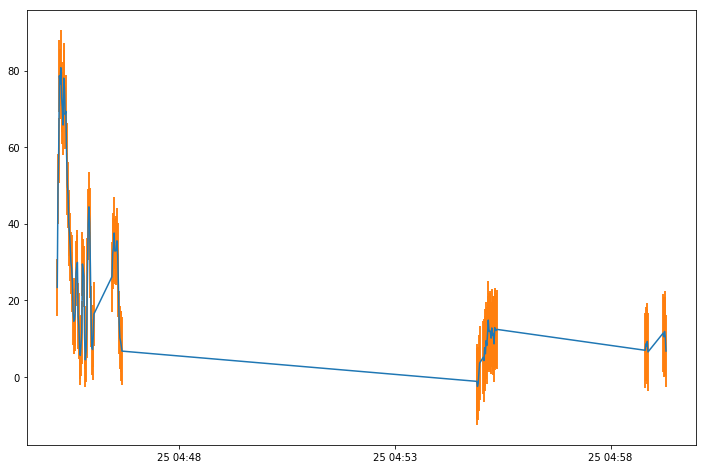

In [40]:


source_df = retrieve_source(reduced, 2579)

_source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
_source_flux[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1)] = np.nan 

plt.figure(figsize=(12,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000)].values,
             _source_flux, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) ].values,
             fmt="-", color="C0",ecolor="C1", label="Low band, det")

In [41]:
_source_flux
# plt.errorbar([1,2,3,4,5,6],[1,2,np.nan,np.nan,5,6], yerr=[1,1,1,1,1,1],fmt="-")

array([ 23.36440689,  23.36440689,  49.06789554,  49.06789554,
        59.02512071,  59.02512071,  78.63717936,  78.63717936,
        76.52056848,  76.52056848,  80.73759736,  80.73759736,
        72.97153398,  72.97153398,  70.28632077,  70.28632077,
        65.77299308,  65.77299308,  78.0218065 ,  78.0218065 ,
        75.41886943,  75.41886943,  68.51834118,  68.51834118,
        69.340992  ,  69.340992  ,  57.82938659,  57.82938659,
        50.3539443 ,  50.3539443 ,  47.55910726,  47.55910726,
        40.07390703,  40.07390703,  37.59477443,  37.59477443,
        33.92862317,  33.92862317,  29.83443395,  29.83443395,
        28.35087751,  28.35087751,  24.7597857 ,  24.7597857 ,
        17.08487365,  17.08487365,  14.50366471,  14.50366471,
        14.91473486,  14.91473486,  16.98003292,  16.98003292,
        27.062037  ,  27.062037  ,  28.76343944,  28.76343944,
        29.88654484,  29.88654484,  15.88734849,  15.88734849,
        13.28092084,  13.28092084,   7.61810299,   7.61

In [49]:
x = np.array([1,2,np.nan,np.nan,5,6])
x[(x == 6)] = 0.

print x

[  1.   2.  nan  nan   5.   0.]


In [162]:
source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values

array([], dtype=float64)

In [17]:
import datetime 

print source_df.taustart_ts[source_df.freq_eff > 60000000].values[0]

print datetime.datetime(year=2018, month=2, day=25,
                       hour=4 , minute=45, second=0)

2017-02-25T04:45:12.000000000+0000
2018-02-25 04:45:00


IndexError: tuple index out of range

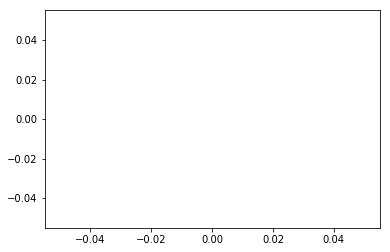

In [174]:
plt.errorbar(np.array([]),np.array([]), yerr=np.array([]), fmt="o",label="nothing")
plt.legend()

In [ ]:
2578

# %matplotlib inline

# i = 3

# source_df = retrieve_source(data, trans_data.runcat.iloc[i])

# print trans_data.runcat.iloc[i]
del source_df

#2579, 2460, 1260, 1985

run_index = 2578 #np.unique(reduced.runcatid)[653]

# for _ID in [2579, 2460, 1260, 1985]:

source_df = retrieve_source(reduced, run_index)

plt.figure(figsize=(12,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values,
             source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values,
             fmt="-", color="C0",ecolor="C1", label="Low band, det")

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
             source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
             fmt=".", color="C4",ecolor="C1", label="Low band, ff")

# plt.ylim([0,80])

# plt.figure(figsize=(24,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values,
             source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values,
             fmt="-",color="C3", ecolor="C1", label="High band, det")

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
             source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
             fmt=".", color="C2",ecolor="C1", label="High band, ff")


plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[0],
         source_df.taustart_ts[source_df.freq_eff > 60000000].values[126]])

plt.legend()

In [209]:
plt.plot(source_df.f_int[source_df.freq_eff > 60000000].values/ source_df.f_int[source_df.freq_eff < 60000000].values, ".")

ValueError: operands could not be broadcast together with shapes (3810,) (3754,) 

(736385.099988426, 736385.1054282407)

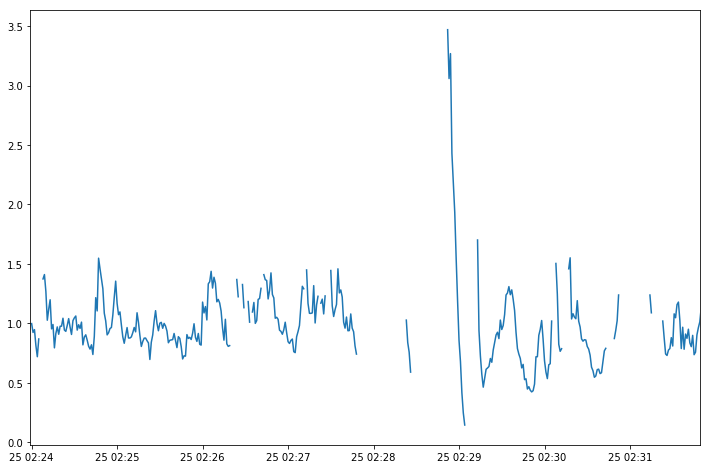

In [224]:
plt.figure(figsize=(12,8))
plt.plot(source_df[source_df.freq_eff > 60000000].set_index("taustart_ts").f_int/source_df[source_df.freq_eff < 60000000].set_index("taustart_ts").f_int)
plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[-623],
         source_df.taustart_ts[source_df.freq_eff > 60000000].values[-223]])

In [179]:
data = data.drop(data.index[data.f)int == np.max(data.taustart_ts)])

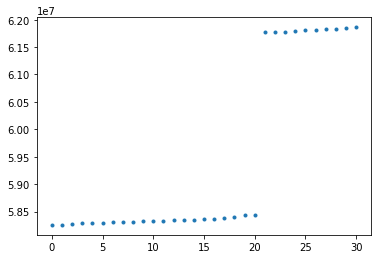

In [132]:
plt.plot(np.unique(data.freq_eff), ".")

data = data.drop(data.index[np.abs(data.f_int) > 10e6])

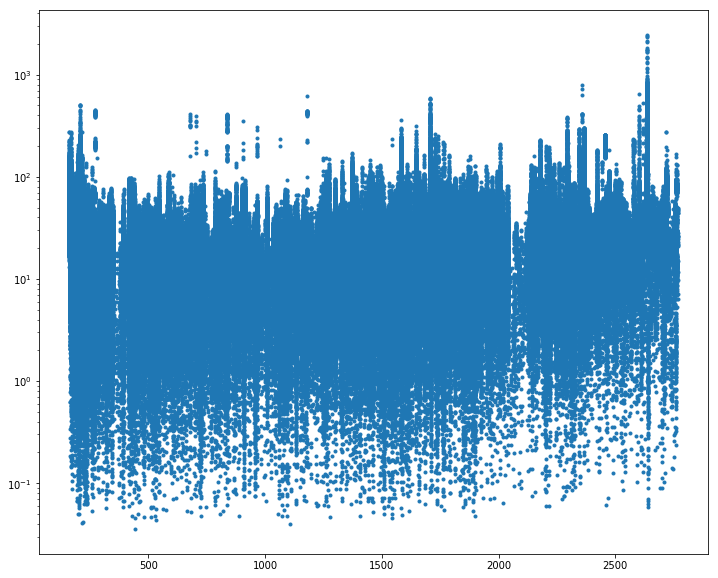

In [118]:
plt.figure(figsize=(12,10))
plt.plot(data.runcatid[data.f_int < 10e5], data.f_int[data.f_int < 10e5], ".")
plt.yscale("log")

In [100]:
np.where(source_df.index.year ==2018)

(array([], dtype=int64),)

In [103]:
data[data.runcatid == 1].wm_ra.iloc[0], data[data.runcatid == 1].wm_decl.iloc[0]

(247.186254743988, 39.399400295862399)

In [108]:
p1 = SkyCoord(ra=(data[data.runcatid == 1].wm_ra.iloc[0]*u.degree),
                  dec=(data[data.runcatid == 1].wm_decl.iloc[0]*u.degree))
lower

<SkyCoord (ICRS): (ra, dec) in deg
    [(  2.47228349e+02,  39.36173231), (  2.47229999e+02,  39.38646435),
     (  2.47059419e+02,  39.41649621), ...,
     (  2.13972986e+02,  29.16307307), (  2.14041150e+02,  29.13051157),
     (  2.14106122e+02,  29.15144207)]>

In [112]:
data[data.band == 2][p1.separation(lower) < 1*u.degree]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
976110,2,1,39.361732,0.094313,6.916444,0,8338,27.719405,7.801233,58300780.0,247.228349,0.125698,1436,1.0,2017-02-25 03:52:01,-3774.611363,39.389354,247.185655,679637
976111,2,1,39.386464,0.063497,5.280496,0,12652,41.296534,7.394331,58398436.0,247.229999,0.080372,1436,1.0,2017-02-25 05:04:25,293.025540,39.389354,247.185655,990833
976112,2,1,39.416496,0.087824,7.619593,0,1146,30.625091,8.697310,58300780.0,247.059419,0.124342,1436,1.0,2017-02-25 01:49:22,33.849953,39.389354,247.185655,90336
976113,2,1,39.507698,0.064061,7.276207,0,7482,45.161754,8.799439,58300780.0,247.159158,0.087084,1436,1.0,2017-02-25 03:37:39,-3569.042293,39.389354,247.185655,626095
976114,2,1,39.336266,0.063424,6.921881,0,8317,45.964468,8.697977,58300780.0,247.266272,0.084522,1436,1.0,2017-02-25 03:51:40,-3769.754660,39.389354,247.185655,678338
976115,2,1,39.396776,0.058862,5.290685,0,12621,44.288620,7.351955,58398436.0,247.246765,0.074535,1436,1.0,2017-02-25 05:03:54,292.667199,39.389354,247.185655,988856
976116,2,1,39.387400,0.069417,5.208353,0,12862,42.100772,8.233360,58346356.0,247.303457,0.087777,1436,1.0,2017-02-25 05:07:57,295.441337,39.389354,247.185655,1004344
976117,2,1,39.435415,0.029826,7.440287,0,3534,67.814379,7.070802,58320312.0,247.106497,0.046193,1436,1.0,2017-02-25 02:29:57,-2433.358354,39.389354,247.185655,294611
976118,2,1,39.459537,0.044953,8.036622,0,2502,43.147697,7.063492,58346356.0,247.121276,0.072149,1436,1.0,2017-02-25 02:12:38,-2043.132334,39.389354,247.185655,203992
976119,2,1,39.331745,0.041637,7.824147,0,6463,83.686397,10.868318,58300780.0,247.180481,0.057871,1436,1.0,2017-02-25 03:20:28,-3310.543269,39.389354,247.185655,552465


In [14]:
reduced_low = data[data.band == 23].groupby("runcatid").mean()
reduced_hi = data[data.band == 24].groupby("runcatid").mean()

In [10]:
%matplotlib inline

plt.figure(figsize=(24,20))

plt.scatter(reduced[reduced.band == 23].groupby("runcatid").first().wm_ra, 
            reduced[reduced.band == 23].groupby("runcatid").first().wm_decl,
            facecolors='none', edgecolors='r',
           s=15)

plt.scatter(reduced[reduced.band == 24].groupby("runcatid").first().wm_ra, 
            reduced[reduced.band == 24].groupby("runcatid").first().wm_decl,
            c="black",
           s=5)

NameError: name 'reduced' is not defined

In [59]:
len(np.unique(reduced.runcatid))

1051

In [40]:
band1 = SkyCoord(ra=(reduced[reduced.band == 1].wm_ra*u.degree).values,
                dec=(reduced[reduced.band == 1].wm_decl*u.degree).values)

band2 = SkyCoord(ra=(reduced[reduced.band == 2].wm_ra*u.degree).values,
                dec=(reduced[reduced.band == 2].wm_decl*u.degree).values)


In [37]:
for i in band1:
    for j in band2:
        if j.lower.match_to_catalog_sky(higher)

<SkyCoord (ICRS): (ra, dec) in deg
    [( 247.18625474,  39.3994003 ), ( 230.18456511,  20.04971211),
     ( 260.93923596,  50.83740648), ..., ( 289.99997387,  74.42867236),
     ( 269.84725218,  46.03556422), ( 287.26150892,  26.98088046)]>

In [43]:
idx1, sep1, d3d1 = band1.match_to_catalog_sky(band2)

In [44]:
idx2, sep2, d3d2 = band2.match_to_catalog_sky(band1)

<IPython.core.display.Javascript object>


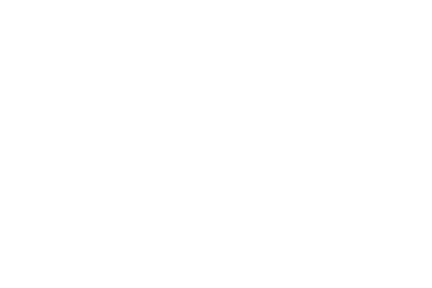

<IPython.core.display.Javascript object>


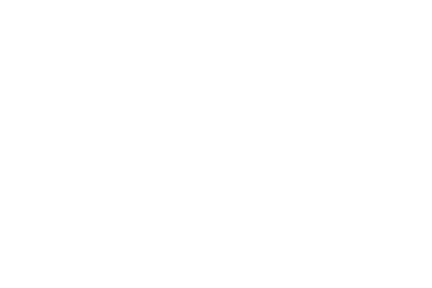

In [40]:
hist = plt.hist(reduced.f_int, bins=100,log=True)


In [39]:
reduced[reduced.band == 2].iloc[6].ra


237.29583399571379

In [55]:
i = 5

print idx1[i],idx2[i]

6 67


In [53]:
np.unique(data.runcatid, return_index=True )[1]

array([      0,     466,   21318, ..., 6322090, 6322122, 6322186])

In [54]:
reduced = data.iloc[np.unique(data.runcatid, return_index=True )[1]]

In [100]:
data[data.runcatid == 160]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
0,23,2,13.575972,0.138752,0.089614,0,61,20.308833,6.762343,61816408.0,145.892648,0.136471,160,1.0,2017-02-25 01:36:14,0.095596,13.618078,145.809975,63288
1,24,2,13.669865,0.125002,0.212004,0,129,18.024957,5.416340,58300780.0,145.859241,0.123152,160,1.0,2017-02-25 01:36:15,0.137115,13.618078,145.809975,63422
2,24,2,13.647891,0.135330,0.216239,0,130,16.950349,5.514295,58300780.0,145.809621,0.133401,160,1.0,2017-02-25 01:36:18,0.138354,13.618078,145.809975,63919
3,24,2,13.556093,0.123966,0.215958,0,131,19.282390,5.735331,58300780.0,145.832763,0.121991,160,1.0,2017-02-25 01:36:20,0.138394,13.618078,145.809975,64241
4,24,2,13.636268,0.143943,0.220440,0,132,16.547213,5.724116,58300780.0,145.862893,0.141815,160,1.0,2017-02-25 01:36:21,0.139827,13.618078,145.809975,64408
5,24,2,13.603691,0.141609,0.228766,0,133,15.543767,5.286593,58320312.0,145.863313,0.139449,160,1.0,2017-02-25 01:36:22,0.141916,13.618078,145.809975,64574
6,23,2,13.629798,0.133267,0.088303,0,62,20.418181,6.534866,61816408.0,145.969921,0.131111,160,1.0,2017-02-25 01:36:23,0.095036,13.618078,145.809975,64780
7,24,2,13.704397,0.125308,0.228254,0,134,19.244757,5.802303,58300780.0,145.837659,0.123610,160,1.0,2017-02-25 01:36:25,0.141913,13.618078,145.809975,65028
8,24,2,13.570758,0.116621,0.226675,0,135,22.371377,6.260916,58300780.0,145.864566,0.114778,160,1.0,2017-02-25 01:36:28,0.141372,13.618078,145.809975,65462
9,24,2,13.602535,0.097502,0.224997,0,136,21.500435,5.031826,58300780.0,145.881201,0.095967,160,1.0,2017-02-25 01:36:29,0.140879,13.618078,145.809975,65618


In [80]:
np.array([data[data.runcatid == 2681].extract_type == 0], dtype=bool) and  np.array([data[data.runcatid == 2681].band == 23], dtype=bool)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [152]:
(np.array([True, False, True, False]) * np.array([True, True, False, False])) * \
(np.array([True, False, True, False]) * np.array([True, True, False, False]))

array([ True, False, False, False], dtype=bool)

In [31]:
(data[(data.runcatid == run_index) & (data.extract_type == 0)].sort_values(by="taustart_ts")) * \
     (data[(data.runcatid == run_index) & (data.band == 23)].sort_values(by="taustart_ts"))

TypeError: ufunc multiply cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [53]:

run_index = 1561
len(data[(data.runcatid == run_index) & \
     (data.band == 23) & \
     (data.extract_type == 0)].set_index("taustart_ts").index.\
intersection(data[(data.runcatid == run_index) & \
     (data.band == 24) & \
     (data.extract_type == 0)].set_index("taustart_ts").index )) > 0

False

In [39]:
np.array([True,True,True,True]) * np.array([False, True, False, True])

array([False,  True, False,  True], dtype=bool)

In [18]:
run_index = 170
(((data[data.runcatid == run_index].extract_type == 0) * \
        (data[data.runcatid == run_index].band == 24)) * \
        ((data[data.runcatid == run_index].extract_type == 0) * \
         (data[data.runcatid == run_index].band == 23))).any()

False

In [22]:
run_index = 170

((data[data.runcatid == run_index].sort_values(by="taustart_ts").extract_type == 0) * \
        (data[data.runcatid == run_index].sort_values(by="taustart_ts").band == 24)) * \
        ((data[data.runcatid == run_index].sort_values(by="taustart_ts").extract_type == 0) * \
         (data[data.runcatid == run_index].sort_values(by="taustart_ts").band == 23))

xtrsrc
8912       False
8950       False
8998       False
9033       False
9114       False
9149       False
9236       False
9304       False
9366       False
9397       False
9547       False
9509       False
9651       False
9680       False
9797       False
9833       False
9950       False
9983       False
10091      False
10130      False
10232      False
10269      False
10493      False
10376      False
10529      False
10565      False
10672      False
10714      False
10817      False
10853      False
           ...  
1393538    False
1394067    False
1398526    False
1398894    False
1399101    False
1401376    False
1402212    False
1402339    False
1402480    False
1402640    False
1402669    False
1403067    False
1403205    False
1403378    False
1403972    False
1404294    False
1404441    False
1404948    False
1406376    False
1406989    False
1408492    False
1409804    False
1409988    False
1410164    False
1410808    False
1412845    False
1424650    False
1465307

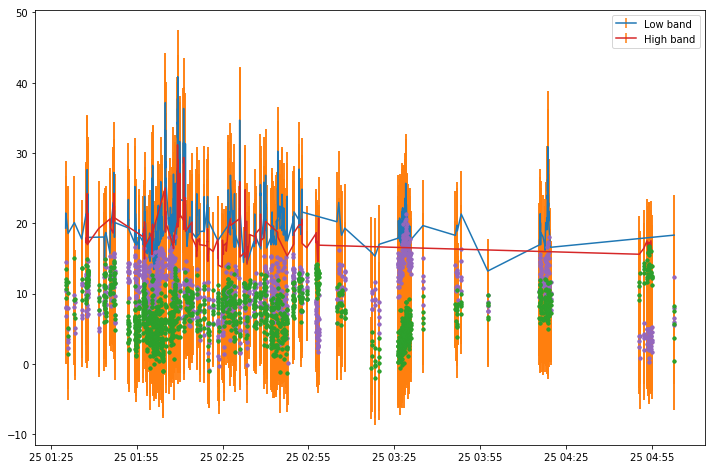

In [46]:

# run_index = 197 #np.unique(reduced.runcatid)[653]

# source_df = retrieve_source(reduced, run_index)

plt.figure(figsize=(12,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values,
             source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values,
             fmt="-", color="C0",ecolor="C1", label="Low band")

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
             source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
             fmt=".", color="C4",ecolor="C1")

# plt.ylim([0,80])

# plt.figure(figsize=(24,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values,
             source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values,
             fmt="-",color="C3", ecolor="C1", label="High band")

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
             source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
             fmt=".", color="C2",ecolor="C1")


# plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[0],
#          source_df.taustart_ts[source_df.freq_eff > 60000000].values[100]])

plt.legend()

In [40]:
source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )]

taustart_ts
2017-02-25 04:15:43   2017-02-25 04:15:43
2017-02-25 02:15:59   2017-02-25 02:15:59
2017-02-25 04:52:14   2017-02-25 04:52:14
2017-02-25 02:15:59   2017-02-25 02:15:59
2017-02-25 04:50:42   2017-02-25 04:50:42
2017-02-25 01:54:32   2017-02-25 01:54:32
2017-02-25 04:53:53   2017-02-25 04:53:53
2017-02-25 02:16:00   2017-02-25 02:16:00
2017-02-25 04:18:36   2017-02-25 04:18:36
2017-02-25 01:54:33   2017-02-25 01:54:33
2017-02-25 04:17:40   2017-02-25 04:17:40
2017-02-25 02:16:00   2017-02-25 02:16:00
2017-02-25 04:53:47   2017-02-25 04:53:47
2017-02-25 01:54:33   2017-02-25 01:54:33
2017-02-25 05:02:48   2017-02-25 05:02:48
2017-02-25 02:16:01   2017-02-25 02:16:01
2017-02-25 04:18:25   2017-02-25 04:18:25
2017-02-25 02:16:01   2017-02-25 02:16:01
2017-02-25 04:16:04   2017-02-25 04:16:04
2017-02-25 01:54:34   2017-02-25 01:54:34
2017-02-25 04:18:49   2017-02-25 04:18:49
2017-02-25 03:27:58   2017-02-25 03:27:58
2017-02-25 04:18:54   2017-02-25 04:18:54
2017-02-25 02:16:02   

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
taustart_ts,,,,,,,,,,,,,,,,,,,
2017-02-25 04:15:43,24,2,60.184518,0.117217,0.970439,0,1644,16.942081,5.934042,58300780.0,206.045852,0.238206,217,1.0,2017-02-25 04:15:43,34.239576,60.072959,205.707171,1764355
2017-02-25 02:15:59,24,2,60.189377,0.109216,0.976201,0,763,21.108213,6.657799,58398436.0,205.600902,0.218915,217,1.0,2017-02-25 02:15:59,23.323211,60.072959,205.707171,462330
2017-02-25 04:52:14,23,2,60.072732,0.145265,0.727423,1,1678,13.536558,6.211568,61816408.0,205.705709,0.301601,217,1.0,2017-02-25 04:52:14,0.633137,60.072959,205.707171,2171089
2017-02-25 02:15:59,23,2,60.163040,0.116613,0.936915,0,723,17.022175,5.733531,61816408.0,205.634044,0.233579,217,1.0,2017-02-25 02:15:59,0.685107,60.072959,205.707171,462379
2017-02-25 04:50:42,24,2,60.072685,0.866656,0.952313,1,1763,2.464056,6.742832,58300780.0,205.705582,1.787640,217,1.0,2017-02-25 04:50:42,35.457295,60.072959,205.707171,2152885
2017-02-25 01:54:32,23,2,60.143863,0.276368,0.759603,1,183,6.509938,5.274109,61816408.0,205.660286,0.557379,217,1.0,2017-02-25 01:54:32,0.465687,60.072959,205.707171,242036
2017-02-25 04:53:53,24,2,60.072795,0.455001,0.971630,1,1781,4.716781,6.807601,58300780.0,205.706083,0.943827,217,1.0,2017-02-25 04:53:53,35.637879,60.072959,205.707171,2186330
2017-02-25 02:16:00,24,2,60.134786,0.107244,0.975756,0,764,21.229441,6.575918,58346356.0,205.614178,0.214633,217,1.0,2017-02-25 02:16:00,23.338497,60.072959,205.707171,462532
2017-02-25 04:18:36,23,2,60.080518,0.280749,0.741611,1,1636,8.842390,7.458837,61816408.0,205.704998,0.569546,217,1.0,2017-02-25 04:18:36,0.641464,60.072959,205.707171,1801049


In [81]:
target_ra = 280
target_decl = 80
radius = 5.

base[(base.ra > target_ra-radius) & (base.ra < target_ra+radius) & \
    (base.decl > target_decl-radius) & (base.decl < target_decl+radius)]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,tau_time,v_int,wm_decl,wm_ra
runcatid,,,,,,,,,,,,,,,,


In [31]:
source_df

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
1315540,24,2,60.184518,0.117217,0.970439,0,1644,16.942081,5.934042,58300780.0,206.045852,0.238206,217,1.0,2017-02-25 04:15:43,34.239576,60.072959,205.707171,1764355
1315541,24,2,60.189377,0.109216,0.976201,0,763,21.108213,6.657799,58398436.0,205.600902,0.218915,217,1.0,2017-02-25 02:15:59,23.323211,60.072959,205.707171,462330
1315542,23,2,60.072732,0.145265,0.727423,1,1678,13.536558,6.211568,61816408.0,205.705709,0.301601,217,1.0,2017-02-25 04:52:14,0.633137,60.072959,205.707171,2171089
1315543,23,2,60.163040,0.116613,0.936915,0,723,17.022175,5.733531,61816408.0,205.634044,0.233579,217,1.0,2017-02-25 02:15:59,0.685107,60.072959,205.707171,462379
1315544,24,2,60.072685,0.866656,0.952313,1,1763,2.464056,6.742832,58300780.0,205.705582,1.787640,217,1.0,2017-02-25 04:50:42,35.457295,60.072959,205.707171,2152885
1315545,23,2,60.143863,0.276368,0.759603,1,183,6.509938,5.274109,61816408.0,205.660286,0.557379,217,1.0,2017-02-25 01:54:32,0.465687,60.072959,205.707171,242036
1315546,24,2,60.072795,0.455001,0.971630,1,1781,4.716781,6.807601,58300780.0,205.706083,0.943827,217,1.0,2017-02-25 04:53:53,35.637879,60.072959,205.707171,2186330
1315547,24,2,60.134786,0.107244,0.975756,0,764,21.229441,6.575918,58346356.0,205.614178,0.214633,217,1.0,2017-02-25 02:16:00,23.338497,60.072959,205.707171,462532
1315548,23,2,60.080518,0.280749,0.741611,1,1636,8.842390,7.458837,61816408.0,205.704998,0.569546,217,1.0,2017-02-25 04:18:36,0.641464,60.072959,205.707171,1801049
1315549,24,2,60.143863,0.194085,0.689747,1,194,12.256567,6.973042,58346356.0,205.660286,0.391273,217,1.0,2017-02-25 01:54:33,0.399574,60.072959,205.707171,242155


In [ ]:
item = 909

plt.figure(figsize=(24,10))
plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 0)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 0)].f_int, ".", c="C0")

plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 1)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 1)].f_int, "+", c="C0")


plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 0)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 0)].f_int, ".", c="C1")
plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 1)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 1)].f_int, "+", c="C1")



In [197]:
unique_xtc = np.unique(data.xtrsrc)

In [206]:
data[data.xtrsrc == unique_xtc[200503]].sort_values(by="taustart_ts")

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
2916306,23,2,27.706732,0.154095,0.110877,1,264,16.395195,6.606272,61816408.0,194.915122,0.157955,689,1.0,2017-02-25 01:51:17,0.130101,27.645818,194.860155,209377
2931199,23,2,27.706732,0.154095,0.110877,1,264,16.395195,6.606272,61816408.0,194.915122,0.157955,689,1.0,2017-02-25 01:51:17,0.130101,27.645818,194.860155,209377


In [73]:
data = data.drop(data.index[(data.set_index("taustart_ts").index.month != 2)])

In [187]:
run_index

1569

In [181]:
data[data.runcatid == run_index].taustart_ts

4977206   2017-02-25 03:26:23
4977207   2017-02-25 03:26:22
4977208   2017-02-25 03:26:19
4977209   2017-02-25 03:26:18
4977210   2017-02-25 03:02:00
4977211   2017-02-25 03:46:41
4977212   2017-02-25 03:26:16
4977213   2017-02-25 02:57:41
4977214   2017-02-25 02:57:42
4977215   2017-02-25 02:57:42
4977216   2017-02-25 02:57:43
4977217   2017-02-25 02:57:44
4977218   2017-02-25 02:57:45
4977219   2017-02-25 02:57:45
4977220   2017-02-25 02:57:46
4977221   2017-02-25 02:57:46
4977222   2017-02-25 02:57:47
4977223   2017-02-25 02:57:47
4977224   2017-02-25 02:57:49
4977225   2017-02-25 02:57:49
4977226   2017-02-25 02:57:50
4977227   2017-02-25 02:57:50
4977228   2017-02-25 02:57:51
4977229   2017-02-25 02:57:51
4977230   2017-02-25 02:57:52
4977231   2017-02-25 02:57:53
4977232   2017-02-25 02:57:54
4977233   2017-02-25 03:26:14
4977234   2017-02-25 03:26:14
4977235   2017-02-25 03:26:13
                  ...        
4977518   2017-02-25 03:26:11
4977519   2017-02-25 03:26:12
4977520   